## 프로젝트: End-to-End OCR

In [ ]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


In [24]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [25]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


### 데이터셋 구성

In [ ]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32), #우리가 원하는 크기 (입력)
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label) #미리 설정해두지 않은 문자는 모두 제거
            label = label[:self.max_text_len] #최대길이까지만

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ] # 배치 크기만큼 인덱스를 가져옴 
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len #CTC Loss에서 필요
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue # 최대길이보다 긴 경우 해당 데이터는 배치에서 공백으로 진행 
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

In [27]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for idx, vocab in enumerate(text):
             try:
                encoded = self.label_map[vocab]
                if idx > 0 and encoded_label[idx-1] == encoded:
                    encoded_label.append(0)
                encoded_label.append(encoded)
             except:
                 continue
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [ ]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

### CRNN 기반의 recognition 모델 학습

In [ ]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

In [30]:
label_converter = LabelConverter(TARGET_CHARACTERS)
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    monitor = 'val_loss',
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5
)


history = model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop]
)

Epoch 1/20
565/565 [==============================] - 91s 144ms/step - loss: 25.6537 - val_loss: 23.7393

Epoch 00001: val_loss improved from inf to 23.73925, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/20
565/565 [==============================] - 81s 143ms/step - loss: 16.4648 - val_loss: 10.2971

Epoch 00002: val_loss improved from 23.73925 to 10.29706, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/20
565/565 [==============================] - 81s 143ms/step - loss: 7.7574 - val_loss: 6.8912

Epoch 00003: val_loss improved from 10.29706 to 6.89118, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/20
565/565 [==============================] - 81s 144ms/step - loss: 5.5359 - val_loss: 5.5910

Epoch 00004: val_loss improved from 6.89118 to 5.59097, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 5/20
565/565 [==============================] - 81s 144ms/step - loss: 4.4168 - val_loss: 4.9995

Epoch 00005: val_loss im

In [ ]:
import json

# history.history 딕셔너리를 JSON 파일로 저장
history_dict = history.history

history_file_path = './history_RCNN.json'
with open(history_file_path, 'w') as f:
    json.dump(history_dict, f)

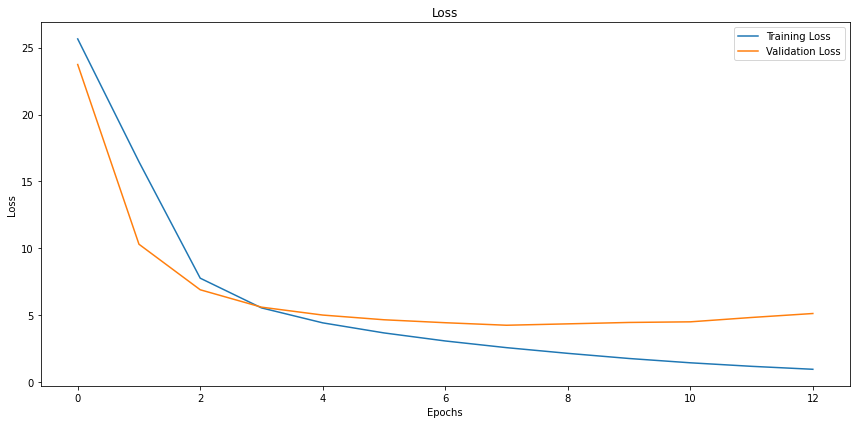

In [34]:
import matplotlib.pyplot as plt

# Loss 그래프
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


val_loss가 적절히 수렴하는 것을 확인

In [ ]:
checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Raw :  [[19 12  9 14 11  9 14  7 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
Result: 	 SLINKING9999999999999999


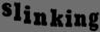

Raw :  [[ 1 12  5 16  0 16 15 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
Result: 	 ALEPPO99999999999999999


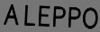

Raw :  [[ 6 23  1 14  4  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
Result: 	 FWANDA999999999999999999


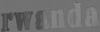

Raw :  [[14  1 20  8  1 14 19 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
Result: 	 NATHANS99999999999999999


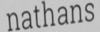

Raw :  [[ 8  1 12  0 12  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
Result: 	 HALLE999999999999999999


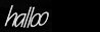

Raw :  [[ 8 21 18 12 19 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
Result: 	 HURLS9999999999999999999


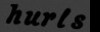

Raw :  [[ 4 15 23 14 19  9 26  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
Result: 	 DOWNSIZE9999999999999999


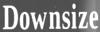

Raw :  [[18 15  2 15 20  9  3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
Result: 	 ROBOTIC99999999999999999


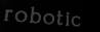

Raw :  [[19 12 15 16  0 16 25 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
Result: 	 SLOPPY99999999999999999


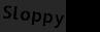

Raw :  [[19  8  5 18 13  9 20  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
Result: 	 SHERMITE9999999999999999


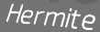

In [10]:
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    print("Raw : ", K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    ))
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        char = chars[index]
        if char != '-': # 궁금해서 추가해본 로직 
            text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

모델이 패딩으로 예측하면 ctc_decode가 -1로 디코딩

```
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
```

TARGET_CHARACTERS[-1]이 9이므로 패딩자리에 9가 채워지는 것으로 파악

In [11]:
def detect_text(img_path):
    # 1. 이미지 로드 및 변환
    img_pil = Image.open(img_path).convert("RGB")  # RGB 변환
    img_np = np.array(img_pil)  # PIL → NumPy 변환
    
    # 2. 배치 차원 추가 및 (H, W, C) 형식 유지
    img_np = np.expand_dims(img_np, axis=0)  # (H, W, C) → (1, H, W, C)
    
    # 3. keras-ocr Detector 사용
    detector = keras_ocr.detection.Detector()
    ocr_result = detector.detect(img_np)[0]  # 첫 번째 배치 결과 가져오기

    # 4. 텍스트 영역 잘라내기
    cropped_imgs = []
    
    for text_result in ocr_result:
        polygon = np.array(text_result)  # 텍스트 영역 좌표
        
        if polygon.ndim == 2 and polygon.shape[0] >= 2:  # 최소한 2개 이상의 점 필요
            # 시각화를 위해 좌표 변환 필요하지만, keras-ocr은 이미 (y, x) 순서이므로 그대로 사용
            x_min, x_max = polygon[:, 0].min() - 5, polygon[:, 0].max() + 5
            y_min, y_max = polygon[:, 1].min() - 5, polygon[:, 1].max() + 5

            # 텍스트 영역 자르기
            word_box = [x_min, y_min, x_max, y_max]
            cropped_imgs.append(img_pil.crop(word_box))
        else:
            print(f"Invalid polygon format: {polygon}")

    return img_pil, cropped_imgs  # crop된 이미지 리스트 반환

In [12]:
import tensorflow as tf
import numpy as np
import PIL
import cv2
import keras_ocr

from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

pil_img, cropped_img = detect_text(SAMPLE_IMG_PATH)

display(cropped_img)

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


[<PIL.Image.Image image mode=RGB size=461x196 at 0x7D1544A26F10>,
 <PIL.Image.Image image mode=RGB size=446x186 at 0x7D14C9DB17C0>]

In [13]:
def recognize_img(pil_img, input_img_size=(100, 32)):
    # 1. 이미지 리사이즈 (input 크기 맞추기)
    pil_img = pil_img.resize(input_img_size, Image.ANTIALIAS)
    
    # 2. PIL → NumPy 변환
    img_np = np.array(pil_img)
    
    # 3. x, y 축 변환 (H, W, C → W, H, C)
    img_np = img_np.transpose(1, 0, 2)  # (100, 32, C) → (32, 100, C)
    
    # 4. 모델 입력 차원 맞추기
    img_np = np.expand_dims(img_np, axis=0)  # (1, 32, 100, C)
    
    # 5. 모델 예측
    output = model_pred.predict(img_np)
    
    # 6. CTC 디코딩하여 텍스트 결과 추출
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-', '')

    print("Result: \t", result)
    display(Image.fromarray(img_np[0].transpose(1, 0, 2).astype(np.uint8)))  # 다시 원래 축으로 변환하여 출력

Raw :  [[22 18 21 16 18 21  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
Result: 	 VRUPRUA99999999999999999


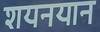

Raw :  [[19 12  5  0  5 16  5 18 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
Result: 	 SLEEPER9999999999999999


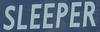

In [14]:
for _img in cropped_img:
    recognize_img(_img)

###  keras-ocr detector와 CRNN recognizer를 엮어 원본 이미지 입력으로부터 text가 출력되는 End-to-End OCR 구성

In [15]:
def simple_end_to_end(img_path):
    img_pil, cropped_imgs = detect_text(img_path)
    for _img in cropped_img:
        recognize_img(_img)

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Raw :  [[22 18 21 16 18 21  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
Result: 	 VRUPRUA99999999999999999


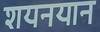

Raw :  [[19 12  5  0  5 16  5 18 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
Result: 	 SLEEPER9999999999999999


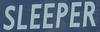

In [16]:
simple_end_to_end(SAMPLE_IMG_PATH)

#### recognition 부분 평가하기 : CER과 WER

#### 1. CER (Character Error Rate)

CER은 모델이 예측한 텍스트와 실제 정답 텍스트의 **문자** 단위 오류를 계산합니다.

#### CER 계산 공식:

$$
\text{CER} = \frac{S + D + I}{N}
$$

- **S** (Substitutions): 잘못된 문자 대체의 수 (예: 'C'가 'G'로 대체됨)
- **D** (Deletions): 예측에서 누락된 문자 수 (예: 'C'가 없고 'ONUNDRUM'만 있음)
- **I** (Insertions): 예측에 잘못 추가된 문자 수 (예: 'C'가 'CONUNDDDRUM'에 두 번 등장)
- **N**: 실제 텍스트의 문자 수 (GT, Ground Truth)

#### 예시:
- 실제 텍스트 (GT): `CONUNDRUM`
- 예측 텍스트 (Pred): `CONUNDRUN`

여기서:
- **S (Substitutions)**: 'M'이 'N'으로 대체됨 → 1번의 대체
- **D (Deletions)**: 없음
- **I (Insertions)**: 없음
- **N**: 실제 텍스트 길이 = 10 (CONUNDRUM)

따라서:

$$
\text{CER} = \frac{1}{10} = 0.1 \quad \text{(즉, 10\% 오류)}
$$

---

#### 2. WER (Word Error Rate)

WER은 텍스트를 **단어 단위**로 나누어 오류를 계산합니다. 이는 주로 음성 인식이나 텍스트 인식에서 사용되며, 모델이 예측한 단어와 실제 단어가 얼마나 다른지를 측정합니다.

#### WER 계산 공식:

$$
\text{WER} = \frac{S + D + I}{N}
$$

- **S** (Substitutions): 잘못된 단어 대체의 수
- **D** (Deletions): 예측에서 누락된 단어 수
- **I** (Insertions): 예측에 잘못 추가된 단어 수
- **N**: 실제 텍스트의 단어 수 (GT)

#### 예시:
- 실제 텍스트 (GT): `CONUNDRUM`
- 예측 텍스트 (Pred): `CONUNDRUN`

여기서:
- **S (Substitutions)**: 'M'이 'N'으로 대체됨 → 1번의 대체
- **D (Deletions)**: 없음
- **I (Insertions)**: 없음
- **N**: 실제 텍스트의 단어 수 = 1 (단어가 하나)

따라서:

$$
\text{WER} = \frac{1}{1} = 1.0 \quad \text{(즉, 100\% 오류)}
$$

---

#### 결론

- **CER**는 문자 단위의 정확도를 평가합니다. CER이 낮을수록 모델이 정확히 예측했다는 뜻입니다.
- **WER**는 단어 단위의 정확도를 평가합니다. WER이 낮을수록 모델이 전체 단어를 정확히 예측했다는 뜻입니다.

따라서, WER이 1.0으로 나온다는 것은 예측한 텍스트가 실제 텍스트와 완전히 다르다는 의미입니다. 이 경우, 모델이 단어를 완전히 틀렸거나, 예측 단어가 전혀 맞지 않는 경우입니다.

#### 테스트 결과 (1000개의 sample)

* Average CER: 0.1279 : 예측한 단어 내의 문자가 83%의 정확도를 보였다는 의미
* Average WER: 0.4320 : 예측한 단어 전체가 온전히 다 맞을 확률은 57% 정도라는 의미


In [45]:
print(f"Total test samples: {test_set.num_samples}")

Total test samples: 891924


In [22]:
import jiwer


def calculate_cer_wer(model, dataset, num_samples=100):
    total_cer, total_wer = 0, 0
    
    for i in range(num_samples):
        # 데이터셋에서 샘플 가져오기
        inputs, outputs = dataset[i]
        img = inputs['input_image'][0:1]  # 배치에서 첫 번째 이미지 선택
        output = model.predict(img)

        # 모델이 예측한 텍스트
        pred_text = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','').rstrip('9')

        # 실제 정답 라벨 (정수 인덱스 → 문자 변환 필요)
        gt_text = label_converter.decode(inputs['label'][0]).replace('-','')

        # CER & WER 계산
        cer = jiwer.cer(gt_text, pred_text)
        wer = jiwer.wer(gt_text, pred_text)

        total_cer += cer
        total_wer += wer

        print(f"Sample {i+1}:")
        print(f"GT : {gt_text}")
        print(f"Pred: {pred_text}")
        print(f"CER: {cer:.4f}, WER: {wer:.4f}")
        print("-" * 30)

    # 평균 CER, WER 출력
    avg_cer = total_cer / num_samples
    avg_wer = total_wer / num_samples
    print(f"Average CER: {avg_cer:.4f}")
    print(f"Average WER: {avg_wer:.4f}")

# 실행
calculate_cer_wer(model_pred, test_set, num_samples=1000)


Raw :  [[19 12  9 14 11  9 14  7 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
Sample 1:
GT : SLINKING
Pred: SLINKING
CER: 0.0000, WER: 0.0000
------------------------------
Raw :  [[ 1 12  5 16  0 16 15 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
Sample 2:
GT : ALEPPO
Pred: ALEPPO
CER: 0.0000, WER: 0.0000
------------------------------
Raw :  [[ 6 23  1 14  4  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
Sample 3:
GT : RWANDA
Pred: FWANDA
CER: 0.1667, WER: 1.0000
------------------------------
Raw :  [[14  1 20  8  1 14 19 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
Sample 4:
GT : NATHANS
Pred: NATHANS
CER: 0.0000, WER: 0.0000
------------------------------
Raw :  [[ 8  1 12  0 12  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
Sample 5:
GT : HALLOO
Pred: HALLE
CER: 0.3333, WER: 1.0000
------------------------------
Raw :  [[ 8 21 18 12 19 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
Sample 6:
GT : HURLS
Pred: HURLS
CER: 0.00

#### 자체적으로 데이터셋 만들 때 유의사항
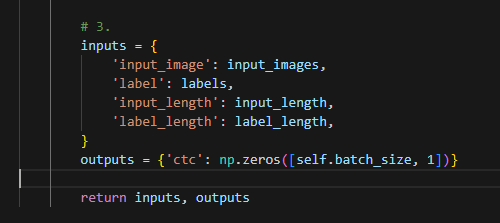

* 모델이 fit할 때, 배치마다 생성되는 입력과 정답은 데이터셋에서 반환하는 첫 번쨰와 두 번째에 매핑되어야 함
* 이름은 똑같고 inputs와 outputs의 순서만 바꿔도 처리하지 못함
```
ValueError: Missing data for input "input_image". You passed a data dictionary with keys ['ctc']. Expected the following keys: ['input_image', 'label', 'input_length', 'label_length']
```

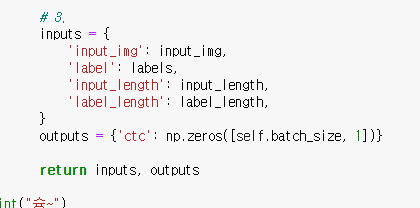
* 입력과 정답의 순서를 맞췄더라도 key값을 맞춰줘야 모델이 처리할 수 있음
* 에러 리포트를 보면, 지정한 레이어들의 이름과 입력의 키값을 매칭해서 처리하는걸 알 수 있음
```
ValueError: Missing data for input "input_image". You passed a data dictionary with keys ['input_img', 'label', 'input_length', 'label_length']. Expected the following keys: ['input_image', 'label', 'input_length', 'label_length']
```

#### CTC LOSS 정리
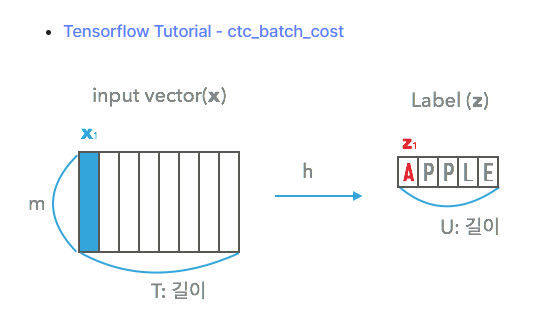

* 노드에서 진행한 방법
```
input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
```
해당 부분이 입력 이미지의 width(100)이어야 된다는 생각에 왜 임의로 정한 것 같은 max_text_len(22)일까를 한참 찾아보고 다양하게 바꿔보면서 알게된 부분을 정리하고자 한다.

max_text_len은 임의로 정한게 맞지만, 어느정도 합리적인 선에서 정해졌다는걸 알 수 있었다. 우선 입력 이미지가 conv층을 거치면서 입력 이미지가 압축되어 (24,1,512)의 피처맵까지 줄어들었을 때, 해당 피처맵을 RNN의 입력으로 사용하려고 (24,512)로 reshape하게 된다. (물론 다르게 reshape하면 max_text_len도 그에 맞춰 적절히 바뀌어야 할 것이다)

따라서 max_text_len은 24를 넘을 수 없다는게 중요한 발견이었다.
그래서 적절한 크기인 22로 정해서 input_length를 위와 같이 정의한 것을 알 수 있다. 물론 24로 해도 문제는 안된다. (억지로 reshape하면 더 늘릴 수 있겠지만 피처맵을 다 섞는거라.. 그건 좀 아니지 않나 싶다)

또 중요한 점은 ctc loss를 계산하는 부분에도 존재한다.
```
K.ctc_batch_cost(labels, y_pred, input_length, label_length)
```
여기서 y_pred(time-step,vocab_size)의 time-step보다 input_length가 길면 계산을 못한다. 차라리 짧으면 계산이 되는 것을 확인할 수 있다. 노드에서는 y_pred의 time-step을 일부러 2개 줄인걸 확인할 수 있는데 max_text_len을 22로 설정해놓았기 때문이라고 생각이 들긴 한다. 왜냐하면 애초에 time-step은 24였을거고 max_text_len을 22로 상황에 맞춰 줄인 걸로 예상하기 때문이다. 둘을 맞추는게 좀 더 좋은 점이 있는 것 같은데 둘을 맞추는 이유까지는 알아내지 못했다.

다시 정리하자면 y_pred의 time-step의 길이는 max_text_len의 길이보다 길기만 하면 계산이 된다. 하지만 짧으면 계산이 안되는 문제가 생긴다.

#### 회고
너무 늦어져서 간단하게 느낀점만 쓰자면, 이번 프로젝트는 어떤 실험을 적극적으로 하기보다 코드에서 의문점을 느껴 코드 분석하는 시간을 가졌던 것 같다. CRNN을 처음 코드로 보고 해석하는 과정에서 너무 오래 걸렸고 다음에 CRNN을 가지고 실험한다면 금방 설계하고 시도해볼 부분들이 떠오른다는 점에서 만족하고 넘어갈 수 있을 것 같다.